# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [1]:
import pandas as pd

flights = pd.read_csv('flights_2019_passengers.csv', delimiter=',')
flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'dep_condition', 'arr_date',
       'arr_condition', 'month', 'year', 'average_seats', 'average_passengers',
       'avg_passenger_capacity_usage'],
      dtype='object')

In [2]:
flights['test_set'] = 'N'

In [3]:
test = pd.read_csv('test_set.csv', delimiter=',')
test = test.dropna()
test['test_set'] = 'Y'

In [4]:
# Outlier detection 

# Finding the IQR
percentile25 = flights['arr_delay'].quantile(0.25)
percentile75 = flights['arr_delay'].quantile(0.75)
iqr = percentile75 - percentile25

# Finding upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Finding Outliers
flights[flights['arr_delay'] > upper_limit]
flights[flights['arr_delay'] < lower_limit]

# Trimming
flights = flights[(flights['arr_delay'] < upper_limit) & (flights['arr_delay'] > lower_limit)]
flights.shape

(106319, 51)

C:\Users\Irene\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Irene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


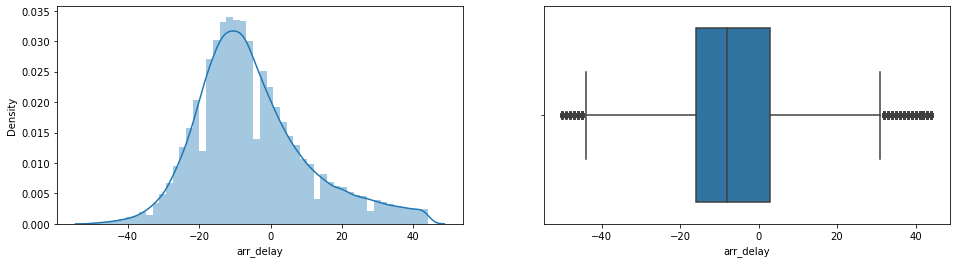

In [5]:
# Compare the plots after trimming
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.distplot(flights['arr_delay'])
plt.subplot(1,2,2)
sns.boxplot(flights['arr_delay'])

plt.show()

In [6]:
flights = pd.concat([flights,test],axis=0)
flights

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,no_name,dep_condition,arr_date,arr_condition,month,year,average_seats,average_passengers,avg_passenger_capacity_usage,test_set
1,2019-01-01,AA,AA_CODESHARE,AA,5606,OH,N575NN,5606,13577,MYR,...,NaN,Cloudy,2019-01-01,Sunny,1,2019,6327.333333,4898.333333,0.774154,N
2,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,10529,BDL,...,NaN,Sunny,2019-01-01,Sunny,1,2019,3516.500000,2697.250000,0.767027,N
3,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,11278,DCA,...,NaN,Sunny,2019-01-01,Sunny,1,2019,3460.000000,2494.500000,0.720954,N
4,2019-01-01,AA,AA_CODESHARE,AA,5608,OH,N710PS,5608,11278,DCA,...,NaN,Sunny,2019-01-01,Partly cloudy,1,2019,1511.000000,847.333333,0.560777,N
5,2019-01-01,AA,AA_CODESHARE,AA,5610,OH,N515AE,5610,13931,ORF,...,NaN,Partly cloudy,2019-01-01,Sunny,1,2019,6123.500000,4888.750000,0.798359,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2020-01-05,AA,AA_CODESHARE,AA,2952,OO,N742SK,2952,12892,LAX,...,NaN,Cloudy,2020-01-05,Sunny,1,2020,3585.700000,2491.400000,0.694816,Y
19996,2020-01-04,DL,DL,DL,1118,DL,N546US,1118,13204,MCO,...,NaN,Patchy rain possible,2020-01-04,Patchy rain possible,1,2020,10788.642857,9196.428571,0.852418,Y
19997,2020-01-01,DL,DL,DL,2767,DL,N881DN,2767,11433,DTW,...,NaN,Partly cloudy,2020-01-01,Partly cloudy,1,2020,5331.300000,3696.600000,0.693377,Y
19998,2020-01-04,WN,WN,WN,3945,WN,N924WN,3945,11042,CLE,...,NaN,Overcast,2020-01-04,Patchy rain possible,1,2020,6742.166667,5293.500000,0.785133,Y


In [7]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126037 entries, 1 to 19999
Data columns (total 51 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   fl_date                       126037 non-null  object 
 1   mkt_unique_carrier            126037 non-null  object 
 2   branded_code_share            126037 non-null  object 
 3   mkt_carrier                   126037 non-null  object 
 4   mkt_carrier_fl_num            126037 non-null  int64  
 5   op_unique_carrier             126037 non-null  object 
 6   tail_num                      126037 non-null  object 
 7   op_carrier_fl_num             126037 non-null  int64  
 8   origin_airport_id             126037 non-null  int64  
 9   origin                        126037 non-null  object 
 10  origin_city_name              126037 non-null  object 
 11  dest_airport_id               126037 non-null  int64  
 12  dest                          126037 non-null

In [8]:
# Dropping non-relevant columns

new_flights = flights.drop(['branded_code_share','mkt_carrier','mkt_carrier_fl_num','op_unique_carrier',
                                'cancelled','cancellation_code','diverted','dup','first_dep_time', 
                                'total_add_gtime','longest_add_gtime', 'no_name', 'origin_airport_id',
                                'origin_city_name','dest_airport_id','dest_city_name', 'dep_time', 
                                'dep_delay','taxi_out', 'wheels_off', 'wheels_on', 'taxi_in','flights',
                               'fl_date','tail_num','op_carrier_fl_num','arr_date','average_seats',
                            'year','arr_time','actual_elapsed_time','air_time'], axis=1)

new_flights = new_flights.drop(['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay'], axis=1)

new_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126037 entries, 1 to 19999
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   mkt_unique_carrier            126037 non-null  object 
 1   origin                        126037 non-null  object 
 2   dest                          126037 non-null  object 
 3   crs_dep_time                  126037 non-null  int64  
 4   crs_arr_time                  126037 non-null  int64  
 5   arr_delay                     106319 non-null  float64
 6   crs_elapsed_time              126037 non-null  int64  
 7   distance                      126037 non-null  int64  
 8   dep_condition                 126037 non-null  object 
 9   arr_condition                 126037 non-null  object 
 10  month                         126037 non-null  int64  
 11  average_passengers            126037 non-null  float64
 12  avg_passenger_capacity_usage  126037 non-null

In [9]:
counts= new_flights['origin'].value_counts()
new_flights = new_flights[~new_flights['origin'].isin(counts[counts < 100].index)] 
# ~ is the negation operator.

In [10]:
counts= new_flights['dest'].value_counts()
new_flights = new_flights[~new_flights['dest'].isin(counts[counts < 100].index)] 
# ~ is the negation operator.

In [11]:
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage,test_set
0,AA,MYR,CLT,2157,2311,-3.0,74,157,Cloudy,Sunny,1,4898.333333,0.774154,N
1,AA,BDL,DCA,1151,1325,6.0,94,313,Sunny,Sunny,1,2697.250000,0.767027,N
2,AA,DCA,BDL,1009,1126,14.0,77,313,Sunny,Sunny,1,2494.500000,0.720954,N
3,AA,DCA,GSP,2000,2134,-12.0,94,396,Sunny,Partly cloudy,1,847.333333,0.560777,N
4,AA,ORF,CLT,1215,1347,-14.0,92,290,Partly cloudy,Sunny,1,4888.750000,0.798359,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111982,AA,LAX,SAN,1339,1435,NaN,56,109,Cloudy,Sunny,1,2491.400000,0.694816,Y
111983,DL,MCO,ATL,1925,2101,NaN,96,404,Patchy rain possible,Patchy rain possible,1,9196.428571,0.852418,Y
111984,DL,DTW,RSW,1225,1522,NaN,177,1084,Partly cloudy,Partly cloudy,1,3696.600000,0.693377,Y
111985,WN,CLE,ATL,725,925,NaN,120,554,Overcast,Patchy rain possible,1,5293.500000,0.785133,Y


In [12]:
def simple_weather(row):
    if row in ['Sunny', 'Clear']:
        return 'Sunny'
    
    elif row in ['Partly cloudy','Overcast','Cloudy']:
        return 'Cloudy'
    
    elif row in ['Torrential rain shower', 'Heavy rain', 'Heavy rain at times']:
        return 'Heavy_rain'

    elif row in ['Moderate rain', 'Moderate rain at times', 'Patchy rain possible',
                 'Light rain shower','Light drizzle','Light rain',
                 'Patchy light rain with thunder', 'Patchy light drizzle', 'Patchy light rain',
                 'Moderate or heavy rain with thunder']:
        return 'Light&Mod_rain'

    elif row in ['Moderate or heavy freezing rain']:
        return 'Freezing_rain'
    
    elif row in ['Mist','Fog', 'Freezing fog']:
        return 'Fog'
    
    elif row in ['Heavy snow', 'Moderate or heavy snow showers', 'Patchy heavy snow', 
                                  'Blizzard', 'Blowing snow', 'Ice pellets']:
        return 'Heavy_snow'
    
    elif row in ['Moderate snow', 'Moderate or heavy snow showers','Patchy moderate snow',
                                  'Moderate or heavy sleet', 'Moderate or heavy snow with thunder', 'Light snow', 'Light sleet', 'Patchy light snow', 'Light sleet showers',
                                  'Patchy sleet possible', 'Light snow showers', 
                                  'Patchy light snow with thunder', 'Patchy snow possible']:
        return 'Light&Mod_snow'
    

    elif row in ['Thundery outbreaks possible']:
        return 'Thunder'
    
'''
    elif row in ['Patchy rain possible','Light rain shower','Light drizzle','Light rain',
                                  'Patchy light rain with thunder', 'Patchy light drizzle', 'Patchy light rain']:
        return 'Light_rain
    elif row in ['Light snow', 'Light sleet', 'Patchy light snow', 'Light sleet showers',
                                  'Patchy sleet possible', 'Light snow showers', 
                                  'Patchy light snow with thunder', 'Patchy snow possible']:
        return 'Light_snow
'''
    

"\n    elif row in ['Patchy rain possible','Light rain shower','Light drizzle','Light rain',\n                                  'Patchy light rain with thunder', 'Patchy light drizzle', 'Patchy light rain']:\n        return 'Light_rain\n    elif row in ['Light snow', 'Light sleet', 'Patchy light snow', 'Light sleet showers',\n                                  'Patchy sleet possible', 'Light snow showers', \n                                  'Patchy light snow with thunder', 'Patchy snow possible']:\n        return 'Light_snow\n"

In [13]:
new_flights['weather_origin_simple'] = new_flights.apply(lambda row: simple_weather(row['dep_condition']), axis=1)
new_flights['weather_origin_simple'].value_counts()

Sunny             52359
Cloudy            38680
Light&Mod_rain    13598
Light&Mod_snow     1527
Heavy_snow         1319
Fog                1166
Heavy_rain          287
Thunder              69
Freezing_rain        27
Name: weather_origin_simple, dtype: int64

In [14]:
wt_counts= new_flights['weather_origin_simple'].value_counts()
new_flights = new_flights[~new_flights['weather_origin_simple'].isin(wt_counts[wt_counts < 100].index)] 
# ~ is the negation operator.
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage,test_set,weather_origin_simple
0,AA,MYR,CLT,2157,2311,-3.0,74,157,Cloudy,Sunny,1,4898.333333,0.774154,N,Cloudy
1,AA,BDL,DCA,1151,1325,6.0,94,313,Sunny,Sunny,1,2697.250000,0.767027,N,Sunny
2,AA,DCA,BDL,1009,1126,14.0,77,313,Sunny,Sunny,1,2494.500000,0.720954,N,Sunny
3,AA,DCA,GSP,2000,2134,-12.0,94,396,Sunny,Partly cloudy,1,847.333333,0.560777,N,Sunny
4,AA,ORF,CLT,1215,1347,-14.0,92,290,Partly cloudy,Sunny,1,4888.750000,0.798359,N,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111886,AA,LAX,SAN,1339,1435,NaN,56,109,Cloudy,Sunny,1,2491.400000,0.694816,Y,Cloudy
111887,DL,MCO,ATL,1925,2101,NaN,96,404,Patchy rain possible,Patchy rain possible,1,9196.428571,0.852418,Y,Light&Mod_rain
111888,DL,DTW,RSW,1225,1522,NaN,177,1084,Partly cloudy,Partly cloudy,1,3696.600000,0.693377,Y,Cloudy
111889,WN,CLE,ATL,725,925,NaN,120,554,Overcast,Patchy rain possible,1,5293.500000,0.785133,Y,Cloudy


In [15]:
new_flights['weather_dest_simple'] = new_flights.apply(lambda row: simple_weather(row['arr_condition']), axis=1)
new_flights['weather_dest_simple'].value_counts()

Sunny             51803
Cloudy            38744
Light&Mod_rain    13830
Light&Mod_snow     1563
Heavy_snow         1560
Fog                1171
Heavy_rain          238
Thunder              91
Freezing_rain        28
Name: weather_dest_simple, dtype: int64

In [16]:
wt_counts= new_flights['weather_dest_simple'].value_counts()
new_flights = new_flights[~new_flights['weather_dest_simple'].isin(wt_counts[wt_counts < 100].index)] 
# ~ is the negation operator.
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage,test_set,weather_origin_simple,weather_dest_simple
0,AA,MYR,CLT,2157,2311,-3.0,74,157,Cloudy,Sunny,1,4898.333333,0.774154,N,Cloudy,Sunny
1,AA,BDL,DCA,1151,1325,6.0,94,313,Sunny,Sunny,1,2697.250000,0.767027,N,Sunny,Sunny
2,AA,DCA,BDL,1009,1126,14.0,77,313,Sunny,Sunny,1,2494.500000,0.720954,N,Sunny,Sunny
3,AA,DCA,GSP,2000,2134,-12.0,94,396,Sunny,Partly cloudy,1,847.333333,0.560777,N,Sunny,Cloudy
4,AA,ORF,CLT,1215,1347,-14.0,92,290,Partly cloudy,Sunny,1,4888.750000,0.798359,N,Cloudy,Sunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111767,AA,LAX,SAN,1339,1435,NaN,56,109,Cloudy,Sunny,1,2491.400000,0.694816,Y,Cloudy,Sunny
111768,DL,MCO,ATL,1925,2101,NaN,96,404,Patchy rain possible,Patchy rain possible,1,9196.428571,0.852418,Y,Light&Mod_rain,Light&Mod_rain
111769,DL,DTW,RSW,1225,1522,NaN,177,1084,Partly cloudy,Partly cloudy,1,3696.600000,0.693377,Y,Cloudy,Cloudy
111770,WN,CLE,ATL,725,925,NaN,120,554,Overcast,Patchy rain possible,1,5293.500000,0.785133,Y,Cloudy,Light&Mod_rain


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [17]:
'''
from pandas_profiling import ProfileReport
profile = ProfileReport(new_flights, title ="Pandas Profiling Report")
profile
'''

'\nfrom pandas_profiling import ProfileReport\nprofile = ProfileReport(new_flights, title ="Pandas Profiling Report")\nprofile\n'

In [18]:
new_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111772 entries, 0 to 111771
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   mkt_unique_carrier            111772 non-null  object 
 1   origin                        111772 non-null  object 
 2   dest                          111772 non-null  object 
 3   crs_dep_time                  111772 non-null  int64  
 4   crs_arr_time                  111772 non-null  int64  
 5   arr_delay                     94714 non-null   float64
 6   crs_elapsed_time              111772 non-null  int64  
 7   distance                      111772 non-null  int64  
 8   dep_condition                 111772 non-null  object 
 9   arr_condition                 111772 non-null  object 
 10  month                         111772 non-null  int64  
 11  average_passengers            111772 non-null  float64
 12  avg_passenger_capacity_usage  111772 non-nul

In [19]:
X_category = new_flights[['mkt_unique_carrier','weather_origin_simple','weather_dest_simple',
                          'origin','dest','test_set','arr_delay']]
X = new_flights.drop(['mkt_unique_carrier','origin','dest','dep_condition','arr_condition',
                      'weather_origin_simple','weather_dest_simple', 'test_set', 'arr_delay'], axis=1)

In [20]:
X_col = X.columns

In [21]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)


In [22]:
# transforming an array back to a data-frame preserves column labels
X_scaled = pd.DataFrame(X_scaled, columns = X_col)

In [23]:
X_scaled = X_scaled.join(X_category)

In [24]:
X_scaled

,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,month,average_passengers,avg_passenger_capacity_usage,mkt_unique_carrier,weather_origin_simple,weather_dest_simple,origin,dest,test_set,arr_delay
0,1.698895,1.599062,-0.983315,-1.141158,-1.249232,0.131924,-0.435542,AA,Cloudy,Sunny,MYR,CLT,N,-3.0
1,-0.346624,-0.291942,-0.705032,-0.875172,-1.249232,-0.533892,-0.518920,AA,Sunny,Sunny,BDL,DCA,N,6.0
2,-0.635355,-0.673594,-0.941572,-0.875172,-1.249232,-0.595223,-1.057882,AA,Sunny,Sunny,DCA,BDL,N,14.0
3,1.379664,1.259602,-0.705032,-0.733654,-1.249232,-1.093481,-2.931631,AA,Sunny,Cloudy,DCA,GSP,N,-12.0
4,-0.216491,-0.249749,-0.732860,-0.914388,-1.249232,0.129025,-0.152401,AA,Cloudy,Sunny,ORF,CLT,N,-14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111767,0.035640,-0.080978,-1.233769,-1.223000,-1.249232,-0.596160,-1.363647,AA,Cloudy,Sunny,LAX,SAN,Y,NaN
111768,1.227165,1.196313,-0.677203,-0.720013,-1.249232,1.432073,0.479977,DL,Light&Mod_rain,Light&Mod_rain,MCO,ATL,Y,NaN
111769,-0.196158,0.085876,0.449842,0.439414,-1.249232,-0.231594,-1.380476,DL,Cloudy,Cloudy,DTW,RSW,Y,NaN
111770,-1.212817,-1.059083,-0.343264,-0.464257,-1.249232,0.251459,-0.307111,WN,Cloudy,Light&Mod_rain,CLE,ATL,Y,NaN


In [25]:
X_scaled = X_scaled.dropna(subset=['weather_origin_simple','weather_dest_simple'])

In [26]:
# One hot encoding for origin and unique_carrier and weather
# are these too many columns now?

onehot_origin = pd.get_dummies(X_scaled[['origin','dest']])
X_scaled = X_scaled.drop('origin', axis=1)
X_scaled = X_scaled.drop('dest', axis=1)
X_scaled = X_scaled.join(onehot_origin)

onehot_carrier = pd.get_dummies(X_scaled['mkt_unique_carrier'])
X_scaled = X_scaled.drop('mkt_unique_carrier', axis=1)
X_scaled = X_scaled.join(onehot_carrier)

onehot_weather = pd.get_dummies(X_scaled[['weather_origin_simple','weather_dest_simple']])
X_scaled = X_scaled.drop(['weather_origin_simple','weather_dest_simple'], axis=1)
X_scaled = X_scaled.join(onehot_weather)

onehot_test = pd.get_dummies(X_scaled['test_set'])
X_scaled = X_scaled.drop('test_set', axis=1)
X_scaled = X_scaled.join(onehot_test)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

##### variance threshold

In [27]:
X_scaled

,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,month,average_passengers,avg_passenger_capacity_usage,arr_delay,origin_ABQ,origin_ALB,...,weather_origin_simple_Sunny,weather_dest_simple_Cloudy,weather_dest_simple_Fog,weather_dest_simple_Heavy_rain,weather_dest_simple_Heavy_snow,weather_dest_simple_Light&Mod_rain,weather_dest_simple_Light&Mod_snow,weather_dest_simple_Sunny,N,Y
0,1.698895,1.599062,-0.983315,-1.141158,-1.249232,0.131924,-0.435542,-3.0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,-0.346624,-0.291942,-0.705032,-0.875172,-1.249232,-0.533892,-0.518920,6.0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,-0.635355,-0.673594,-0.941572,-0.875172,-1.249232,-0.595223,-1.057882,14.0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,1.379664,1.259602,-0.705032,-0.733654,-1.249232,-1.093481,-2.931631,-12.0,0,0,...,1,1,0,0,0,0,0,0,1,0
4,-0.216491,-0.249749,-0.732860,-0.914388,-1.249232,0.129025,-0.152401,-14.0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111767,0.035640,-0.080978,-1.233769,-1.223000,-1.249232,-0.596160,-1.363647,NaN,0,0,...,0,0,0,0,0,0,0,1,0,1
111768,1.227165,1.196313,-0.677203,-0.720013,-1.249232,1.432073,0.479977,NaN,0,0,...,0,0,0,0,0,1,0,0,0,1
111769,-0.196158,0.085876,0.449842,0.439414,-1.249232,-0.231594,-1.380476,NaN,0,0,...,0,1,0,0,0,0,0,0,0,1
111770,-1.212817,-1.059083,-0.343264,-0.464257,-1.249232,0.251459,-0.307111,NaN,0,0,...,0,0,0,0,0,1,0,0,0,1


In [28]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.01)
X_transform = vt.fit_transform(X_scaled)

In [29]:
X_transform.shape

(106219, 102)

In [30]:
# columns we have selected
# get_support() is method of VarianceThreshold and stores boolean of each variable in the numpy array.
selected_columns = X_scaled.columns[vt.get_support()]
# transforming an array back to a data-frame preserves column labels
X_transform = pd.DataFrame(X_transform, columns = selected_columns)

In [31]:
X_transform = X_transform.dropna(subset=['average_passengers','avg_passenger_capacity_usage'])

In [32]:
y = X_transform['arr_delay'] 
test_sample = X_transform[['N','Y']]
X_transform = X_transform.drop(['arr_delay','N','Y'], axis=1)

In [33]:
import numpy as np 

# step 1
X_corr = X_transform.corr().abs()

# step 2
indices = np.where(X_corr > 0.85) 
indices = [(X_corr.index[x], X.columns[y]) 
for x, y in zip(*indices)
    if x != y and x < y]

# step 3
for idx in indices: #each pair
    try:
        X_transform.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [34]:
print(indices)

[('crs_elapsed_time', 'distance')]


In [35]:
X_transform = X_transform.join(test_sample)

# To do forward regression for dimentionality reduction, we need to split the test set data in this step. 
And then change the columns of test set by dropping columns in the original x_transform data?

In [36]:
X_pred = X_transform[X_transform['Y'] == 1]
X_transform = X_transform[X_transform['N'] == 1]

In [37]:
X_transform.columns

Index(['crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'month',
       'average_passengers', 'avg_passenger_capacity_usage', 'origin_ATL',
       'origin_AUS', 'origin_BNA', 'origin_BOS', 'origin_BWI', 'origin_CLT',
       'origin_DAL', 'origin_DCA', 'origin_DEN', 'origin_DFW', 'origin_DTW',
       'origin_EWR', 'origin_FLL', 'origin_HOU', 'origin_IAD', 'origin_IAH',
       'origin_JFK', 'origin_LAS', 'origin_LAX', 'origin_LGA', 'origin_MCO',
       'origin_MDW', 'origin_MIA', 'origin_MSP', 'origin_OAK', 'origin_ORD',
       'origin_PDX', 'origin_PHL', 'origin_PHX', 'origin_SAN', 'origin_SEA',
       'origin_SFO', 'origin_SJC', 'origin_SLC', 'origin_STL', 'dest_ATL',
       'dest_AUS', 'dest_BNA', 'dest_BOS', 'dest_BWI', 'dest_CLT', 'dest_DAL',
       'dest_DCA', 'dest_DEN', 'dest_DFW', 'dest_DTW', 'dest_EWR', 'dest_FLL',
       'dest_HOU', 'dest_IAD', 'dest_IAH', 'dest_JFK', 'dest_LAS', 'dest_LAX',
       'dest_LGA', 'dest_MCO', 'dest_MDW', 'dest_MIA', 'dest_MSP', 'dest_OAK',
    

In [38]:
y = y.dropna()

In [39]:
X_transform.shape

(89358, 100)

In [40]:
y.shape

(89358,)

### below forward regression to reduce # of variables was not used in the regression models

In [41]:
from sklearn.feature_selection import f_regression, SelectKBest

skb = SelectKBest(f_regression, k=50)
X = skb.fit_transform(X_transform, y)

In [42]:

skb.get_support()
# column names
X_transform.columns[skb.get_support()]
X = pd.DataFrame(X,columns=X_transform.columns[skb.get_support()])

In [43]:
X

,crs_dep_time,crs_arr_time,crs_elapsed_time,month,average_passengers,origin_BNA,origin_BOS,origin_BWI,origin_CLT,origin_DAL,...,UA,WN,weather_origin_simple_Cloudy,weather_origin_simple_Heavy_snow,weather_origin_simple_Light&Mod_snow,weather_origin_simple_Sunny,weather_dest_simple_Fog,weather_dest_simple_Heavy_snow,weather_dest_simple_Light&Mod_snow,weather_dest_simple_Sunny
0,1.698895,1.599062,-0.983315,-1.249232,0.131924,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.346624,-0.291942,-0.705032,-1.249232,-0.533892,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.635355,-0.673594,-0.941572,-1.249232,-0.595223,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.379664,1.259602,-0.705032,-1.249232,-1.093481,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.216491,-0.249749,-0.732860,-1.249232,0.129025,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89353,1.806660,1.683448,-0.551976,1.689711,-0.196585,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89354,-1.436482,-1.298815,-0.551976,1.689711,-0.196585,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89355,-0.785821,0.082040,1.117721,1.689711,-0.566032,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
89356,-1.639814,-0.838530,0.839438,1.689711,-0.663243,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

#####  #1. Linear Regression

In [44]:
import statsmodels.api as sm
X_con = sm.add_constant(X_transform) # adding a constant

C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [45]:
y = list(y)

lin_reg = sm.OLS(y,X_con)
# performing the regression
# and fitting the model
result = sm.OLS(y, X_con).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     50.80
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:04:36   Log-Likelihood:            -3.7177e+05
No. Observations:               89358   AIC:                         7.437e+05
Df Residuals:                   89259   BIC:                         7.447e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [46]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_transform, y)

regressor.score(X_transform,y) # R-squared

0.05282602586624019

#####  #3. Random Forest

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_transform, y, test_size=0.3, random_state=42)


In [48]:
'''# Grid search CV done
from sklearn.ensemble import RandomForestRegressor # Import Random Forest Regressor
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': 30,
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': 1000,
    
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
'''

"# Grid search CV done\nfrom sklearn.ensemble import RandomForestRegressor # Import Random Forest Regressor\nfrom sklearn.model_selection import GridSearchCV\n# Create the parameter grid based on the results of random search \nparam_grid = {\n    'bootstrap': [True],\n    'max_depth': 30,\n    'max_features': [2, 3],\n    'min_samples_leaf': [3, 4, 5],\n    'min_samples_split': [2, 5, 10],\n    'n_estimators': 1000,\n    \n}\n# Create a based model\nrf = RandomForestRegressor()\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid, \n                          cv = 3, n_jobs = -1, verbose = 2)\n\n# Fit the grid search to the data\ngrid_search.fit(X_train, y_train)\ngrid_search.best_params_\n"

In [49]:
'grid_search.best_estimator_'

SyntaxError: EOL while scanning string literal (1092139284.py, line 1)

In [50]:
from sklearn.ensemble import RandomForestRegressor # Import Random Forest Regressory
regr = RandomForestRegressor(max_depth=30, n_estimators = 1000)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=1000)

In [51]:
y_pred = regr.predict(X_test)

In [52]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred, squared=False)

# R-squared scores
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 11.05
Mean Squared Error: 14.45
R-squared scores: 0.18


In [72]:
# Feature importance based on mean descrease in impurity
importance = regr.feature_importances_

Feature: 0, Score: 0.13102
Feature: 1, Score: 0.11863
Feature: 2, Score: 0.11646
Feature: 3, Score: 0.07619
Feature: 4, Score: 0.10913
Feature: 5, Score: 0.10882
Feature: 6, Score: 0.00366
Feature: 7, Score: 0.00192
Feature: 8, Score: 0.00296
Feature: 9, Score: 0.00334
Feature: 10, Score: 0.00344
Feature: 11, Score: 0.00296
Feature: 12, Score: 0.00239
Feature: 13, Score: 0.00367
Feature: 14, Score: 0.00582
Feature: 15, Score: 0.00343
Feature: 16, Score: 0.00298
Feature: 17, Score: 0.00402
Feature: 18, Score: 0.00274
Feature: 19, Score: 0.00132
Feature: 20, Score: 0.00224
Feature: 21, Score: 0.00242
Feature: 22, Score: 0.00398
Feature: 23, Score: 0.00303
Feature: 24, Score: 0.00414
Feature: 25, Score: 0.00821
Feature: 26, Score: 0.00308
Feature: 27, Score: 0.00336
Feature: 28, Score: 0.00164
Feature: 29, Score: 0.00587
Feature: 30, Score: 0.00192
Feature: 31, Score: 0.00676
Feature: 32, Score: 0.00196
Feature: 33, Score: 0.00441
Feature: 34, Score: 0.00409
Feature: 35, Score: 0.00224
Fe

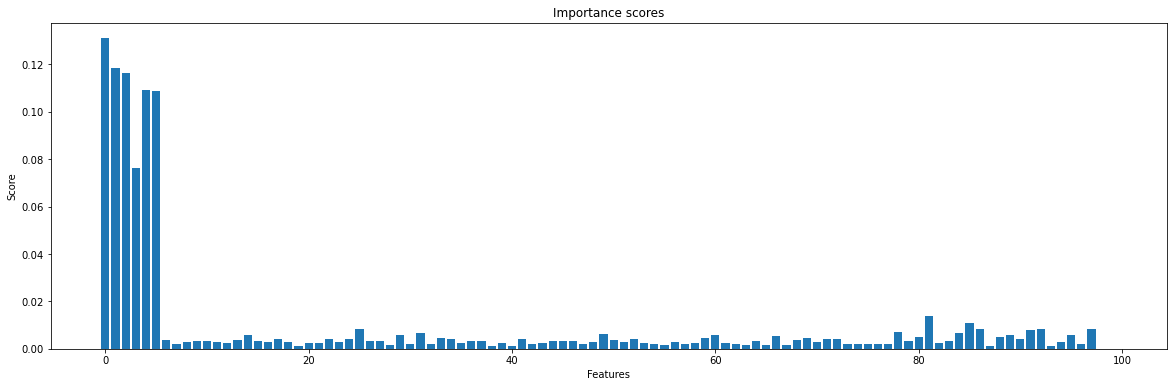

In [77]:
for i, v in enumerate(importance):
    print ('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
fig = plt.figure() 
# Figure size
fig.set_size_inches(20, 6)
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Importance scores')
plt.show()

##### Lasso Regression - R^2 = 0.00 (--- because trained data is not overfitting, but underfitting)

In [53]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [54]:
# Mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred, squared=False)

# R-squared scores
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 12.23
Mean Squared Error: 15.84
R-squared scores: 0.01


##### Ridge Regression - not so useful (R^2 = 0.05) (--- because trained data is not overfitting, but underfitting)

In [55]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [56]:
# Mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred, squared=False)

# R-squared scores
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 12.03
Mean Squared Error: 15.55
R-squared scores: 0.05


##### PCA - regression

In [57]:
# Step 1 — Initial Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test= train_test_split(X_transform, y, test_size=0.3, random_state=42)

# Step 2 — Standardize Features - already done

In [58]:
## Step 3 — Run Baseline Regression Models
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Linear Regression
lin_reg = LinearRegression().fit(X_train, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test), squared=False)

# Lasso Regression
lasso_reg = LassoCV().fit(X_train, y_train)
lasso_score_train = -1 * cross_val_score(lasso_reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test), squared=False)

# Ridge Regression
ridge_reg = RidgeCV().fit(X_train, y_train)
ridge_score_train = -1 * cross_val_score(ridge_reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test), squared=False)

In [59]:
# Step 4 — Generate Principal Components

# Generate all the principal components
pca = PCA() # Default n_components = min(n_samples, n_features)
X_train_pc = pca.fit_transform(X_train)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.706892,0.029625,0.022638,-0.030627,-0.010968,0.072061,0.640758,0.283672,0.010637,0.012675,...,-0.000306,0.000194,0.001143,0.006523,-0.000715,0.001030,-0.000145,-0.000611,0.0,0.0
1,-0.702627,0.076065,-0.029846,-0.005435,0.006067,-0.062473,-0.640989,-0.289024,-0.014619,-0.013009,...,0.000118,0.000402,0.000698,0.001748,0.000092,-0.000885,0.000058,0.000519,0.0,0.0
2,0.045431,0.674773,-0.352583,0.216576,0.587762,0.096792,0.040409,0.003360,-0.070475,0.011990,...,0.005017,-0.006136,-0.000789,0.001679,0.014025,-0.002312,0.000402,0.000155,0.0,0.0
3,0.036924,0.170639,0.128948,-0.892504,0.144851,0.332325,-0.043816,-0.003627,-0.106584,-0.080372,...,-0.002781,0.001333,0.004162,-0.000033,-0.000248,0.000835,-0.000460,-0.000119,0.0,0.0
4,0.010982,0.283020,0.903613,0.212072,0.149474,0.063733,-0.028042,-0.008320,0.116737,0.037414,...,-0.012312,0.001622,0.015233,-0.000550,0.011131,-0.009955,-0.000146,0.000163,0.0,0.0


In [60]:
'''with the first principal component (containing the most information) located in the leftmost column.
We can also view the explained variance of each principal component'''

'with the first principal component (containing the most information) located in the leftmost column.\nWe can also view the explained variance of each principal component'

In [61]:
pca.explained_variance_ratio_

array([1.82150519e-01, 1.52299758e-01, 1.11101753e-01, 1.05041095e-01,
       5.65801037e-02, 4.62446829e-02, 3.59233603e-02, 3.43577901e-02,
       2.90093568e-02, 2.16905530e-02, 1.89638242e-02, 1.69184968e-02,
       1.67089776e-02, 7.14007853e-03, 4.60220440e-03, 4.44931500e-03,
       4.37691579e-03, 4.15043638e-03, 4.02305392e-03, 3.87019071e-03,
       3.77015170e-03, 3.61297940e-03, 3.47286644e-03, 3.38756909e-03,
       3.21880388e-03, 3.19559890e-03, 3.17165566e-03, 3.09441793e-03,
       2.98283236e-03, 2.90973535e-03, 2.87722106e-03, 2.76671568e-03,
       2.74730699e-03, 2.56992101e-03, 2.47962284e-03, 2.40176177e-03,
       2.37320195e-03, 2.35511951e-03, 2.27931744e-03, 2.24674030e-03,
       2.18275975e-03, 2.10935535e-03, 2.09986479e-03, 2.08195389e-03,
       2.07893160e-03, 2.02147486e-03, 2.00611716e-03, 1.98964507e-03,
       1.96612234e-03, 1.92215669e-03, 1.88211591e-03, 1.87363061e-03,
       1.86201594e-03, 1.85404247e-03, 1.82598185e-03, 1.79708094e-03,
      

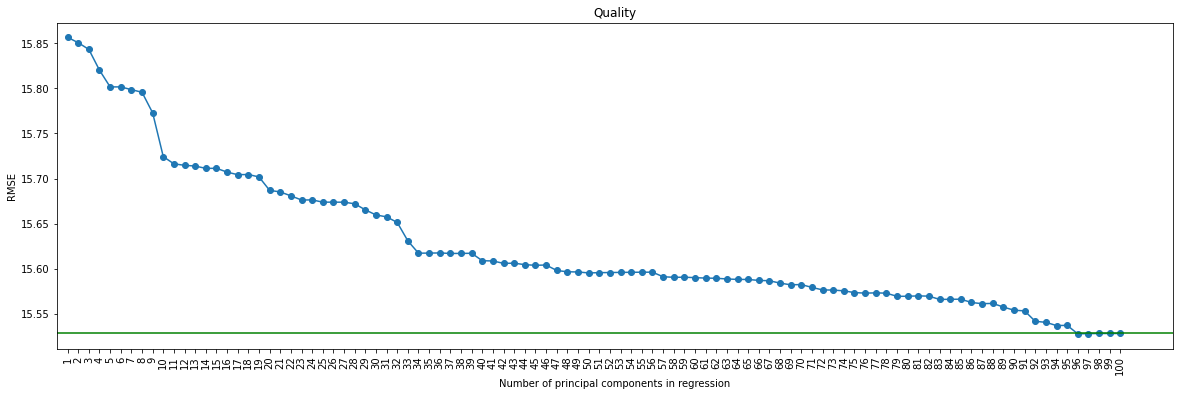

In [62]:
# Step 5 — Determine the Number of Principal Components

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
fig = plt.figure() 
# Figure size
fig.set_size_inches(20, 6)

plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.xticks(rotation=90)
plt.axhline(y=lr_score_train, color='g', linestyle='-');

In [63]:
# Step 6 — Run PCR with Best Number of Principal Components

# Visually determine optimal number of principal components from above plot
best_pc_num = 34

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 9 principal components of test set
X_test_pc = pca.transform(X_test)[:,:best_pc_num]

# Predict on test data
y_pred = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, y_pred, squared=False)

In [64]:
# Mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred, squared=False)

# R-squared scores
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 12.1
Mean Squared Error: 15.63
R-squared scores: 0.04


#####  #4. Naive Bayes - classifier - not tried

#####  #5. SVM  - Alex

#####  #6. XGBoost

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

#### 1. Linear Regression

#### 2. Random Forest regression

In [65]:
# test set prediction on Random Forest regression as the MSE/MAE/R-squared
y_ts_pred = regr.predict(X_pred)

In [66]:
test_pred = pd.DataFrame(y_ts_pred, columns = ['RF_pred'])

In [69]:
test_pred

,RF_pred
0,-6.696358
1,-16.777646
2,3.055710
3,-2.510261
4,-14.462326
...,...
16856,-2.930560
16857,-17.377578
16858,-15.669448
16859,-5.188325


In [70]:
# prediction on test_set info
test_pred.describe()

,RF_pred
count,16861.000000
mean,-3.478263
std,7.186024
min,-34.705366
25%,-7.639046
50%,-3.684310
75%,0.063752
max,31.865767


In [71]:
# Original data 'arr_delay' info
flights['arr_delay'].describe()

count    106319.000000
mean         -5.021351
std          15.847358
min         -50.000000
25%         -16.000000
50%          -8.000000
75%           3.000000
max          44.000000
Name: arr_delay, dtype: float64

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.